In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
import wandb_util.wandb_util as wbu
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [2]:
from wandb_util.wandb_util import ExperimentConfig


config = OmegaConf.load('config/experiments/gr_benchmark_big.yaml')
config = ExperimentConfig(**config)
config.exp_name = "benchmark_big"

config.sync_experiment()

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/benchmark_big/workspace
Experiment up-to-date!


In [3]:
from scripts.wandb_experiments.benchmark import split_runs

exp_name = "benchmark_big"

runs = wbu.get_logged_runs(exp_name)
print(wbu.get_exp_url(exp_name))
texture_runs, video_gen_runs = split_runs(runs)
print(len(video_gen_runs))

https://wandb.ai/romeu/diffusion-3D-features/groups/benchmark_big/workspace
216


In [4]:
from text3d2video.util import group_into_array, map_array

def scene_key(run):
    config = OmegaConf.create(run.config)
    return f"{config.animation_tag}-{config.prompt}"

def method_key(run):
    return run.name.split("_")[0]

all_runs_grouped, all_labels = group_into_array(video_gen_runs, [method_key, scene_key])
all_runs_grouped.shape

(24, 7)

In [ ]:
from scripts.wandb_runs.run_generative_rendering import RunGenerativeRenderingConfig

method_configs = map_array(
    all_runs_grouped[:, 0],
    lambda r: RunGenerativeRenderingConfig(**OmegaConf.create(r.config)),
)

In [54]:
alpha_exp_indices = []

for i, method in enumerate(method_configs):
    # use src tag
    if method.src_anim_tag is None:
        continue

    # no texture
    if method.texture_tag is not None:
        continue

    if method.start_noise_level != 0.0:
        continue

    alpha_exp_indices.append(i)


In [58]:
import numpy as np

from text3d2video.util import index_list

method_indices = alpha_exp_indices
scene_indices = [0,1,2,3,4]
runs_grouped = all_runs_grouped[np.ix_(method_indices, scene_indices)]

method_labels = index_list(all_labels[0], method_indices)
scene_labels = index_list(all_labels[1], scene_indices)
labels = [method_labels, scene_labels]

In [59]:
from text3d2video.experiment_analysis import VideoTraces

run_data = map_array(runs_grouped, VideoTraces.from_run, pbar=True)

  7%|▋         | 1/15 [00:01<00:14,  1.02s/it]wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   20 of 20 files downloaded.  
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   25 of 25 files downloaded.  mwandb: \ 1 of 25 files downloaded...
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   25 of 25 files downloaded.  mwandb: \ 1 of 25 files downloaded...
wandb:   20 of 20 files downloaded.  mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  4mwandb: \ 1 of 20 files downloaded...
wandb:   20 of 20 files downloaded.  4mwandb: \ 1 of 20 files downloaded...
wandb:   25 of 25 files downloaded.  4mwandb: \ 1 of 25 files downloaded...
wandb:   20 of 20 files downloaded.  4mwandb: \ 1 of 

In [61]:
from text3d2video.utilities.video_comparison import video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip


run_data.shape

vids = map_array(run_data, lambda run: pil_frames_to_clip(run.frames))
vid = video_grid(vids)

vid.write_videofile("benchmark_big.mp4")

Moviepy - Building video benchmark_big.mp4.
Moviepy - Writing video benchmark_big.mp4



Moviepy - Done !
Moviepy - video ready benchmark_big.mp4


In [ ]:
from einops import rearrange
from text3d2video.util import map_object_array, object_array

frame_indices = [0, 1, 2, 3]

ims = map_object_array(
    run_data, lambda x: object_array(index_list(x.frames, frame_indices))
)
ims = rearrange(ims, "method scene frame -> scene method frame")

TypeError: Image data of dtype object cannot be converted to float

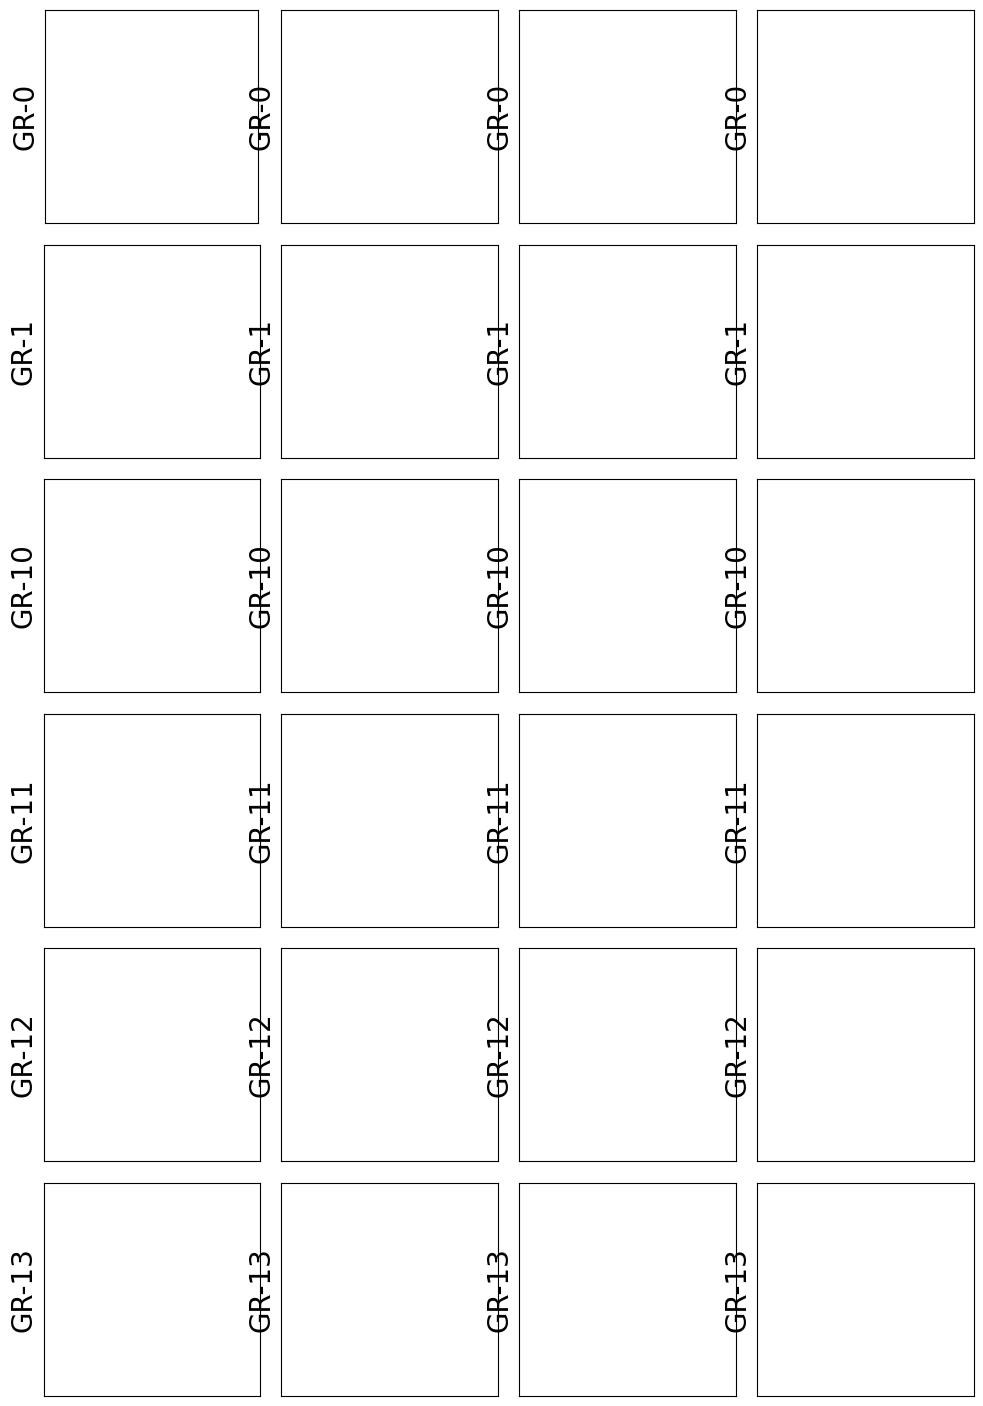

In [36]:
from matplotlib import pyplot as plt
from text3d2video.utilities.matplotlib_utils import make_grid


fig, axs = make_grid(list(ims.shape), dim_labels={1: method_labels}, scale=3)

for idx, ax in np.ndenumerate(axs):
    ax.imshow(ims[idx])

plt.savefig("outs/mpl_figs/benchmark_qual.png", bbox_inches="tight", dpi=200)